# Data Preprocessing for Collaborative Filtering

This notebook implements comprehensive data preprocessing based on EDA insights:

**Key Preprocessing Steps:**
1. Filter cold-start users and movies
2. Handle rating biases (user & item biases)
3. Temporal train/test split
4. Feature engineering (genres, demographics)
5. Normalize and scale ratings
6. Prepare data for collaborative filtering models

---

## 1. Setup and Load Data

In [1]:
# Standard libraries
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append(str(Path().absolute().parent))

# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Surprise library
from surprise import Dataset, Reader

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully!")
print(f"✓ Working directory: {Path().absolute()}")

✓ All libraries imported successfully!
✓ Working directory: /Users/sameenmubashar/Desktop/Sameen/xai-collaborative-filtering/notebooks


In [2]:
# Load processed data from notebook 01
data_dir = Path('../data/processed')

print("Loading processed data...")
ratings_df = pd.read_csv(data_dir / 'ratings_1m.csv')
movies_df = pd.read_csv(data_dir / 'movies_1m.csv')
users_df = pd.read_csv(data_dir / 'users_1m.csv')
merged_df = pd.read_csv(data_dir / 'merged_1m.csv')

# Convert timestamp back to datetime
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'])
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# Convert genre_list from string back to list
import ast
movies_df['genre_list'] = movies_df['genre_list'].apply(ast.literal_eval)

print(f"\n✓ Loaded {len(ratings_df):,} ratings")
print(f"✓ Loaded {len(movies_df):,} movies")
print(f"✓ Loaded {len(users_df):,} users")
print(f"✓ Loaded {len(merged_df):,} merged records")

Loading processed data...

✓ Loaded 1,000,209 ratings
✓ Loaded 3,883 movies
✓ Loaded 6,040 users
✓ Loaded 1,000,209 merged records


## 2. Filter Cold-Start Users and Movies

Remove users and movies with insufficient ratings for reliable modeling.

In [3]:
# Set thresholds
MIN_USER_RATINGS = 20  # Users must have at least 20 ratings
MIN_MOVIE_RATINGS = 20  # Movies must have at least 20 ratings

print("="*60)
print("FILTERING COLD-START USERS AND MOVIES")
print("="*60)

# Count ratings per user and movie
user_counts = ratings_df.groupby('user_id').size()
movie_counts = ratings_df.groupby('movie_id').size()

print(f"\nBefore filtering:")
print(f"  Total ratings: {len(ratings_df):,}")
print(f"  Unique users: {ratings_df['user_id'].nunique():,}")
print(f"  Unique movies: {ratings_df['movie_id'].nunique():,}")

# Filter users and movies
valid_users = user_counts[user_counts >= MIN_USER_RATINGS].index
valid_movies = movie_counts[movie_counts >= MIN_MOVIE_RATINGS].index

print(f"\nFiltering criteria:")
print(f"  Min ratings per user: {MIN_USER_RATINGS}")
print(f"  Min ratings per movie: {MIN_MOVIE_RATINGS}")
print(f"\n  Users removed: {len(user_counts) - len(valid_users):,}")
print(f"  Movies removed: {len(movie_counts) - len(valid_movies):,}")

# Apply filters
filtered_ratings = ratings_df[
    (ratings_df['user_id'].isin(valid_users)) &
    (ratings_df['movie_id'].isin(valid_movies))
].copy()

print(f"\nAfter filtering:")
print(f"  Total ratings: {len(filtered_ratings):,}")
print(f"  Unique users: {filtered_ratings['user_id'].nunique():,}")
print(f"  Unique movies: {filtered_ratings['movie_id'].nunique():,}")
print(f"  Retention rate: {len(filtered_ratings)/len(ratings_df)*100:.2f}%")

# Update movies and users dataframes
filtered_movies = movies_df[movies_df['movie_id'].isin(valid_movies)].copy()
filtered_users = users_df[users_df['user_id'].isin(valid_users)].copy()

print(f"\n✓ Cold-start filtering complete!")

FILTERING COLD-START USERS AND MOVIES

Before filtering:
  Total ratings: 1,000,209
  Unique users: 6,040
  Unique movies: 3,706

Filtering criteria:
  Min ratings per user: 20
  Min ratings per movie: 20

  Users removed: 0
  Movies removed: 663

After filtering:
  Total ratings: 995,492
  Unique users: 6,040
  Unique movies: 3,043
  Retention rate: 99.53%

✓ Cold-start filtering complete!


## 3. Compute Rating Statistics and Biases

Calculate global, user, and movie rating statistics.

In [4]:
print("="*60)
print("COMPUTING RATING STATISTICS")
print("="*60)

# Global statistics
global_mean = filtered_ratings['rating'].mean()
global_std = filtered_ratings['rating'].std()

print(f"\nGlobal Rating Statistics:")
print(f"  Mean: {global_mean:.4f}")
print(f"  Std: {global_std:.4f}")
print(f"  Min: {filtered_ratings['rating'].min()}")
print(f"  Max: {filtered_ratings['rating'].max()}")

# User biases (how much each user deviates from global mean)
user_mean_ratings = filtered_ratings.groupby('user_id')['rating'].mean()
user_biases = user_mean_ratings - global_mean

print(f"\nUser Bias Statistics:")
print(f"  Mean user bias: {user_biases.mean():.4f}")
print(f"  Std user bias: {user_biases.std():.4f}")
print(f"  Most generous user bias: +{user_biases.max():.2f}")
print(f"  Most critical user bias: {user_biases.min():.2f}")

# Movie biases (how much each movie deviates from global mean)
movie_mean_ratings = filtered_ratings.groupby('movie_id')['rating'].mean()
movie_biases = movie_mean_ratings - global_mean

print(f"\nMovie Bias Statistics:")
print(f"  Mean movie bias: {movie_biases.mean():.4f}")
print(f"  Std movie bias: {movie_biases.std():.4f}")
print(f"  Highest rated movie bias: +{movie_biases.max():.2f}")
print(f"  Lowest rated movie bias: {movie_biases.min():.2f}")

# Add biases to dataframe
filtered_ratings['user_bias'] = filtered_ratings['user_id'].map(user_biases)
filtered_ratings['movie_bias'] = filtered_ratings['movie_id'].map(movie_biases)

# Mean-centered ratings (for matrix factorization)
filtered_ratings['rating_centered'] = filtered_ratings['rating'] - global_mean

print(f"\n✓ Rating statistics computed!")

COMPUTING RATING STATISTICS

Global Rating Statistics:
  Mean: 3.5841
  Std: 1.1158
  Min: 1
  Max: 5

User Bias Statistics:
  Mean user bias: 0.1206
  Std user bias: 0.4288
  Most generous user bias: +1.38
  Most critical user bias: -2.57

Movie Bias Statistics:
  Mean movie bias: -0.2849
  Std movie bias: 0.6085
  Highest rated movie bias: +1.02
  Lowest rated movie bias: -2.27

✓ Rating statistics computed!


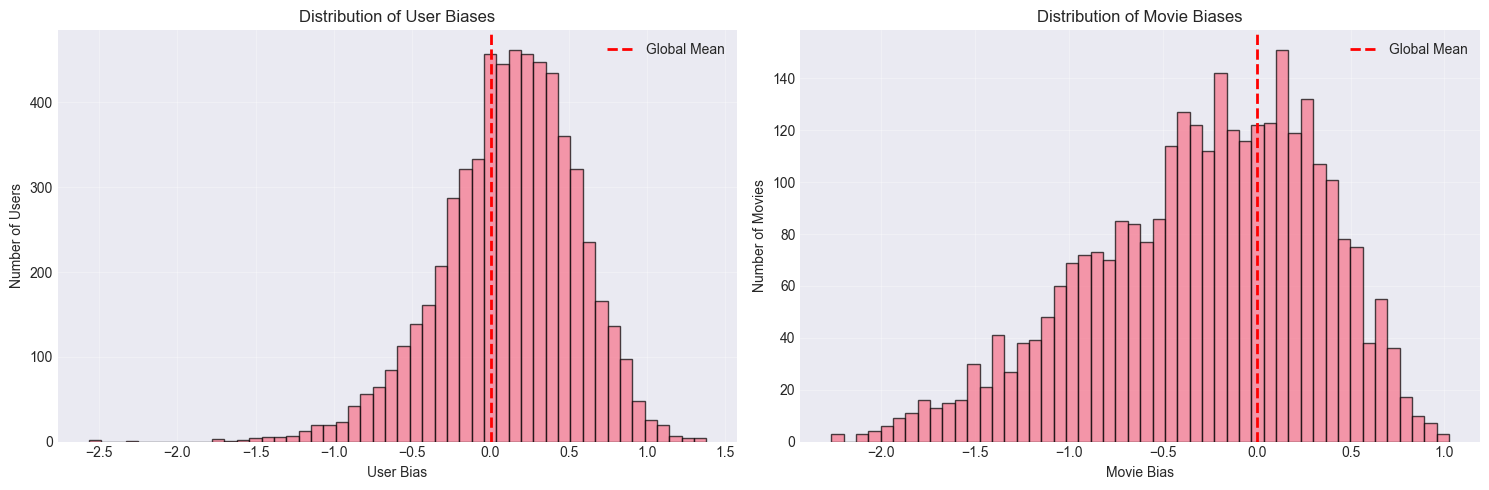


📊 Interpretation:
  • Negative bias = tends to rate lower than average
  • Positive bias = tends to rate higher than average
  • User biases show individual rating tendencies
  • Movie biases show overall movie quality perception


In [5]:
# Visualize biases
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# User bias distribution
axes[0].hist(user_biases, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Global Mean')
axes[0].set_xlabel('User Bias')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of User Biases')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Movie bias distribution
axes[1].hist(movie_biases, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Global Mean')
axes[1].set_xlabel('Movie Bias')
axes[1].set_ylabel('Number of Movies')
axes[1].set_title('Distribution of Movie Biases')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  • Negative bias = tends to rate lower than average")
print("  • Positive bias = tends to rate higher than average")
print("  • User biases show individual rating tendencies")
print("  • Movie biases show overall movie quality perception")

## 4. Temporal Train/Test Split

Split data temporally to simulate real-world scenario where we predict future ratings.

In [6]:
print("="*60)
print("TEMPORAL TRAIN/TEST SPLIT")
print("="*60)

# Sort by timestamp
filtered_ratings = filtered_ratings.sort_values('timestamp').reset_index(drop=True)

# Define split ratio
TRAIN_RATIO = 0.8
split_idx = int(len(filtered_ratings) * TRAIN_RATIO)

# Split data
train_df = filtered_ratings.iloc[:split_idx].copy()
test_df = filtered_ratings.iloc[split_idx:].copy()

print(f"\nSplit Strategy: Temporal (chronological)")
print(f"Train ratio: {TRAIN_RATIO*100:.0f}%")
print(f"Test ratio: {(1-TRAIN_RATIO)*100:.0f}%")

print(f"\nTrain Set:")
print(f"  Ratings: {len(train_df):,}")
print(f"  Users: {train_df['user_id'].nunique():,}")
print(f"  Movies: {train_df['movie_id'].nunique():,}")
print(f"  Date range: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")

print(f"\nTest Set:")
print(f"  Ratings: {len(test_df):,}")
print(f"  Users: {test_df['user_id'].nunique():,}")
print(f"  Movies: {test_df['movie_id'].nunique():,}")
print(f"  Date range: {test_df['timestamp'].min()} to {test_df['timestamp'].max()}")

# Check for users/movies in test but not in train (cold-start in test)
test_cold_users = set(test_df['user_id']) - set(train_df['user_id'])
test_cold_movies = set(test_df['movie_id']) - set(train_df['movie_id'])

print(f"\nCold-Start in Test Set:")
print(f"  New users (not in train): {len(test_cold_users)}")
print(f"  New movies (not in train): {len(test_cold_movies)}")

if len(test_cold_users) > 0 or len(test_cold_movies) > 0:
    print(f"\n⚠️ Warning: Some users/movies in test set don't appear in train set")
    print(f"   This simulates cold-start problem (realistic scenario)")

print(f"\n✓ Temporal split complete!")

TEMPORAL TRAIN/TEST SPLIT

Split Strategy: Temporal (chronological)
Train ratio: 80%
Test ratio: 20%

Train Set:
  Ratings: 796,393
  Users: 5,399
  Movies: 3,041
  Date range: 2000-04-25 23:05:32 to 2000-12-02 10:27:14

Test Set:
  Ratings: 199,099
  Users: 1,784
  Movies: 3,042
  Date range: 2000-12-02 10:27:14 to 2003-02-28 17:49:50

Cold-Start in Test Set:
  New users (not in train): 641
  New movies (not in train): 2

⚠️ Warning: Some users/movies in test set don't appear in train set
   This simulates cold-start problem (realistic scenario)

✓ Temporal split complete!


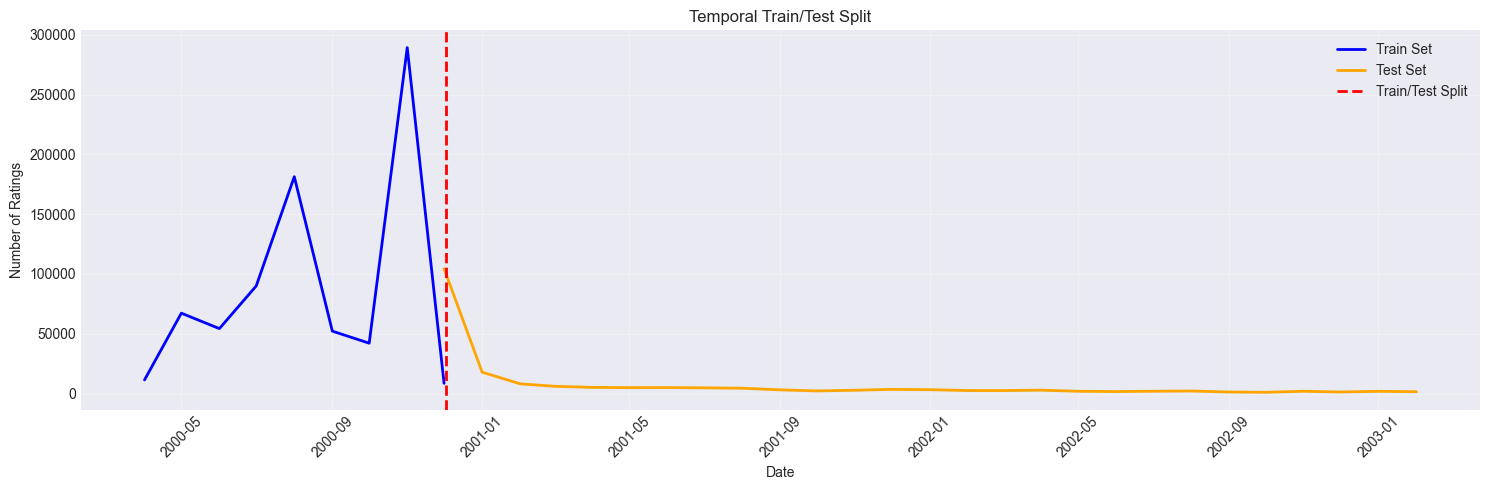


📊 Temporal split ensures:
  • Model trained on past data
  • Evaluation on future data (realistic)
  • No data leakage from future to past


In [7]:
# Visualize temporal split
train_df['year_month'] = train_df['timestamp'].dt.to_period('M')
test_df['year_month'] = test_df['timestamp'].dt.to_period('M')

train_counts = train_df.groupby('year_month').size()
test_counts = test_df.groupby('year_month').size()

plt.figure(figsize=(15, 5))
plt.plot(train_counts.index.to_timestamp(), train_counts.values, 
         linewidth=2, label='Train Set', color='blue')
plt.plot(test_counts.index.to_timestamp(), test_counts.values, 
         linewidth=2, label='Test Set', color='orange')
plt.axvline(train_df['timestamp'].max(), color='red', linestyle='--', 
            linewidth=2, label='Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.title('Temporal Train/Test Split')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n📊 Temporal split ensures:")
print("  • Model trained on past data")
print("  • Evaluation on future data (realistic)")
print("  • No data leakage from future to past")

## 5. Feature Engineering

### 5.1 Genre Features (Multi-Hot Encoding)

In [8]:
print("="*60)
print("GENRE FEATURE ENGINEERING")
print("="*60)

# Multi-hot encode genres
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(filtered_movies['genre_list'])
genre_features = pd.DataFrame(
    genre_matrix,
    columns=mlb.classes_,
    index=filtered_movies['movie_id']
)

print(f"\nGenre Features:")
print(f"  Movies: {len(genre_features)}")
print(f"  Unique genres: {len(mlb.classes_)}")
print(f"  Feature shape: {genre_features.shape}")
print(f"\nGenres: {list(mlb.classes_)}")

# Add genre features to movies dataframe
filtered_movies = filtered_movies.merge(
    genre_features,
    left_on='movie_id',
    right_index=True,
    how='left'
)

print(f"\n✓ Genre features created!")
print(f"\nSample genre features for first movie:")
print(filtered_movies[mlb.classes_].iloc[0])

GENRE FEATURE ENGINEERING

Genre Features:
  Movies: 3043
  Unique genres: 18
  Feature shape: (3043, 18)

Genres: ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

✓ Genre features created!

Sample genre features for first movie:
Action         0
Adventure      0
Animation      1
Children's     1
Comedy         1
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
Name: 0, dtype: int64


### 5.2 User Demographic Features

In [9]:
print("="*60)
print("USER DEMOGRAPHIC FEATURE ENGINEERING")
print("="*60)

# One-hot encode demographics
gender_encoded = pd.get_dummies(filtered_users['gender'], prefix='gender')
age_encoded = pd.get_dummies(filtered_users['age_group'], prefix='age')
occupation_encoded = pd.get_dummies(filtered_users['occupation_name'], prefix='occ')

# Combine all demographic features
demographic_features = pd.concat([
    filtered_users[['user_id']],
    gender_encoded,
    age_encoded,
    occupation_encoded
], axis=1)

print(f"\nDemographic Features:")
print(f"  Users: {len(demographic_features)}")
print(f"  Total features: {demographic_features.shape[1] - 1}")  # -1 for user_id
print(f"    Gender features: {len(gender_encoded.columns)}")
print(f"    Age features: {len(age_encoded.columns)}")
print(f"    Occupation features: {len(occupation_encoded.columns)}")

# Merge with filtered_users
filtered_users = filtered_users.merge(
    demographic_features,
    on='user_id',
    how='left'
)

print(f"\n✓ Demographic features created!")
print(f"\nSample demographic features for first user:")
demo_cols = list(gender_encoded.columns) + list(age_encoded.columns)[:3]
print(filtered_users[demo_cols].iloc[0])

USER DEMOGRAPHIC FEATURE ENGINEERING

Demographic Features:
  Users: 6040
  Total features: 30
    Gender features: 2
    Age features: 7
    Occupation features: 21

✓ Demographic features created!

Sample demographic features for first user:
gender_F      True
gender_M     False
age_18-24    False
age_25-34    False
age_35-44    False
Name: 0, dtype: bool


### 5.3 User Genre Preferences

In [10]:
print("="*60)
print("USER GENRE PREFERENCE FEATURES")
print("="*60)

# Calculate average rating per user per genre (on training data)
# This is important for XAI - we can explain recommendations based on genre preferences

# Merge train data with movies to get genres
train_with_movies = train_df.merge(
    filtered_movies[['movie_id', 'genre_list']],
    on='movie_id',
    how='left'
)

# Explode genres (one row per user-movie-genre combination)
train_exploded = train_with_movies.explode('genre_list')

# Calculate average rating per user per genre
user_genre_prefs = train_exploded.groupby(['user_id', 'genre_list'])['rating'].agg([
    ('avg_rating', 'mean'),
    ('count', 'size')
]).reset_index()

# Pivot to create user-genre preference matrix
user_genre_matrix = user_genre_prefs.pivot(
    index='user_id',
    columns='genre_list',
    values='avg_rating'
).fillna(global_mean)  # Fill missing with global mean

print(f"\nUser-Genre Preference Matrix:")
print(f"  Users: {user_genre_matrix.shape[0]}")
print(f"  Genres: {user_genre_matrix.shape[1]}")
print(f"  Shape: {user_genre_matrix.shape}")

print(f"\n✓ User genre preferences computed!")
print(f"\nSample preferences for first user:")
print(user_genre_matrix.iloc[0])

USER GENRE PREFERENCE FEATURES

User-Genre Preference Matrix:
  Users: 5399
  Genres: 18
  Shape: (5399, 18)

✓ User genre preferences computed!

Sample preferences for first user:
genre_list
Action         4.370370
Adventure      4.066667
Animation      3.666667
Children's     4.000000
Comedy         4.000000
Crime          4.000000
Documentary    3.584080
Drama          4.111111
Fantasy        4.250000
Film-Noir      5.000000
Horror         3.906250
Musical        5.000000
Mystery        3.584080
Romance        4.000000
Sci-Fi         4.131579
Thriller       3.846154
War            4.500000
Western        3.584080
Name: 636, dtype: float64

User-Genre Preference Matrix:
  Users: 5399
  Genres: 18
  Shape: (5399, 18)

✓ User genre preferences computed!

Sample preferences for first user:
genre_list
Action         4.370370
Adventure      4.066667
Animation      3.666667
Children's     4.000000
Comedy         4.000000
Crime          4.000000
Documentary    3.584080
Drama          4.1111

## 6. Normalize Features

Scale numerical features for neural network models.

In [11]:
print("="*60)
print("FEATURE NORMALIZATION")
print("="*60)

# Normalize ratings to [0, 1] scale (for neural networks)
train_df['rating_normalized'] = (train_df['rating'] - 1) / 4
test_df['rating_normalized'] = (test_df['rating'] - 1) / 4

print(f"\nRating Normalization:")
print(f"  Original range: [1, 5]")
print(f"  Normalized range: [0, 1]")
print(f"  Train mean: {train_df['rating_normalized'].mean():.4f}")
print(f"  Test mean: {test_df['rating_normalized'].mean():.4f}")

# Standardize user genre preferences (mean=0, std=1)
scaler = StandardScaler()
user_genre_scaled = pd.DataFrame(
    scaler.fit_transform(user_genre_matrix),
    index=user_genre_matrix.index,
    columns=user_genre_matrix.columns
)

print(f"\nUser-Genre Preference Standardization:")
print(f"  Mean: ~0.0 (standardized)")
print(f"  Std: ~1.0 (standardized)")

print(f"\n✓ Feature normalization complete!")

FEATURE NORMALIZATION

Rating Normalization:
  Original range: [1, 5]
  Normalized range: [0, 1]
  Train mean: 0.6482
  Test mean: 0.6373

User-Genre Preference Standardization:
  Mean: ~0.0 (standardized)
  Std: ~1.0 (standardized)

✓ Feature normalization complete!


## 7. Prepare Data for Surprise Library

Format data for collaborative filtering algorithms (SVD, KNN, etc.)

In [12]:
print("="*60)
print("PREPARE DATA FOR SURPRISE LIBRARY")
print("="*60)

# Create Reader object with rating scale
reader = Reader(rating_scale=(1, 5))

# Load train and test sets
surprise_train = Dataset.load_from_df(
    train_df[['user_id', 'movie_id', 'rating']],
    reader
).build_full_trainset()

# Convert test set to surprise format
surprise_test = [
    (row['user_id'], row['movie_id'], row['rating'])
    for _, row in test_df.iterrows()
]

print(f"\nSurprise Trainset:")
print(f"  Number of ratings: {surprise_train.n_ratings}")
print(f"  Number of users: {surprise_train.n_users}")
print(f"  Number of items: {surprise_train.n_items}")
print(f"  Rating scale: {surprise_train.rating_scale}")
print(f"  Global mean: {surprise_train.global_mean:.4f}")

print(f"\nSurprise Testset:")
print(f"  Number of ratings: {len(surprise_test)}")

print(f"\n✓ Data ready for Surprise library!")

PREPARE DATA FOR SURPRISE LIBRARY

Surprise Trainset:
  Number of ratings: 796393
  Number of users: 5399
  Number of items: 3041
  Rating scale: (1, 5)
  Global mean: 3.5928

Surprise Testset:
  Number of ratings: 199099

✓ Data ready for Surprise library!

Surprise Trainset:
  Number of ratings: 796393
  Number of users: 5399
  Number of items: 3041
  Rating scale: (1, 5)
  Global mean: 3.5928

Surprise Testset:
  Number of ratings: 199099

✓ Data ready for Surprise library!


## 8. Create Complete Feature Matrices

Combine all features for hybrid models.

In [13]:
print("="*60)
print("COMPLETE FEATURE MATRICES")
print("="*60)

# Movie features: genres + popularity + bias
movie_popularity = train_df.groupby('movie_id').size().rename('popularity')
movie_avg_rating = train_df.groupby('movie_id')['rating'].mean().rename('avg_rating')

movie_features_complete = filtered_movies[['movie_id', 'year']].merge(
    genre_features,
    left_on='movie_id',
    right_index=True,
    how='left'
).merge(
    movie_popularity,
    left_on='movie_id',
    right_index=True,
    how='left'
).merge(
    movie_avg_rating,
    left_on='movie_id',
    right_index=True,
    how='left'
).fillna(0)

print(f"\nMovie Feature Matrix:")
print(f"  Shape: {movie_features_complete.shape}")
print(f"  Features: {movie_features_complete.shape[1] - 1}")  # -1 for movie_id
print(f"    Genre features: {len(mlb.classes_)}")
print(f"    Metadata: year, popularity, avg_rating")

# User features: demographics + activity + bias
user_activity = train_df.groupby('user_id').size().rename('num_ratings')
user_avg_rating = train_df.groupby('user_id')['rating'].mean().rename('avg_rating')

demo_cols = list(gender_encoded.columns) + list(age_encoded.columns) + list(occupation_encoded.columns)
user_features_complete = filtered_users[['user_id'] + demo_cols].merge(
    user_activity,
    left_on='user_id',
    right_index=True,
    how='left'
).merge(
    user_avg_rating,
    left_on='user_id',
    right_index=True,
    how='left'
).fillna(0)

print(f"\nUser Feature Matrix:")
print(f"  Shape: {user_features_complete.shape}")
print(f"  Features: {user_features_complete.shape[1] - 1}")  # -1 for user_id
print(f"    Demographic features: {len(demo_cols)}")
print(f"    Activity: num_ratings, avg_rating")

print(f"\n✓ Complete feature matrices created!")

COMPLETE FEATURE MATRICES

Movie Feature Matrix:
  Shape: (3043, 22)
  Features: 21
    Genre features: 18
    Metadata: year, popularity, avg_rating

User Feature Matrix:
  Shape: (6040, 33)
  Features: 32
    Demographic features: 30
    Activity: num_ratings, avg_rating

✓ Complete feature matrices created!


## 9. Save Preprocessed Data

In [14]:
# Create output directory
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

print("="*60)
print("SAVING PREPROCESSED DATA")
print("="*60)

# Save train/test splits
train_df.to_csv(output_dir / 'train_set.csv', index=False)
test_df.to_csv(output_dir / 'test_set.csv', index=False)
print(f"\n✓ Saved train_set.csv ({len(train_df):,} records)")
print(f"✓ Saved test_set.csv ({len(test_df):,} records)")

# Save feature matrices
movie_features_complete.to_csv(output_dir / 'movie_features.csv', index=False)
user_features_complete.to_csv(output_dir / 'user_features.csv', index=False)
print(f"✓ Saved movie_features.csv ({movie_features_complete.shape[0]} movies, {movie_features_complete.shape[1]-1} features)")
print(f"✓ Saved user_features.csv ({user_features_complete.shape[0]} users, {user_features_complete.shape[1]-1} features)")

# Save user-genre preferences
user_genre_matrix.to_csv(output_dir / 'user_genre_preferences.csv')
print(f"✓ Saved user_genre_preferences.csv")

# Save metadata
metadata = {
    'preprocessing_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'min_user_ratings': MIN_USER_RATINGS,
    'min_movie_ratings': MIN_MOVIE_RATINGS,
    'train_ratio': TRAIN_RATIO,
    'global_mean': global_mean,
    'global_std': global_std,
    'train_size': len(train_df),
    'test_size': len(test_df),
    'num_users': filtered_ratings['user_id'].nunique(),
    'num_movies': filtered_ratings['movie_id'].nunique(),
    'num_genres': len(mlb.classes_),
    'genres': list(mlb.classes_)
}

import json
with open(output_dir / 'preprocessing_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Saved preprocessing_metadata.json")

print(f"\n✓ All preprocessed data saved to {output_dir}")

SAVING PREPROCESSED DATA

✓ Saved train_set.csv (796,393 records)
✓ Saved test_set.csv (199,099 records)
✓ Saved movie_features.csv (3043 movies, 21 features)
✓ Saved user_features.csv (6040 users, 32 features)
✓ Saved user_genre_preferences.csv
✓ Saved preprocessing_metadata.json

✓ All preprocessed data saved to ../data/processed

✓ Saved train_set.csv (796,393 records)
✓ Saved test_set.csv (199,099 records)
✓ Saved movie_features.csv (3043 movies, 21 features)
✓ Saved user_features.csv (6040 users, 32 features)
✓ Saved user_genre_preferences.csv
✓ Saved preprocessing_metadata.json

✓ All preprocessed data saved to ../data/processed


## 10. Preprocessing Summary

In [15]:
print("="*60)
print("PREPROCESSING SUMMARY")
print("="*60)

print(f"\n📊 Data Statistics:")
print(f"  Original ratings: {len(ratings_df):,}")
print(f"  Filtered ratings: {len(filtered_ratings):,} ({len(filtered_ratings)/len(ratings_df)*100:.1f}% retained)")
print(f"  Train ratings: {len(train_df):,} ({len(train_df)/len(filtered_ratings)*100:.1f}%)")
print(f"  Test ratings: {len(test_df):,} ({len(test_df)/len(filtered_ratings)*100:.1f}%)")

print(f"\n👥 User Statistics:")
print(f"  Total users: {filtered_ratings['user_id'].nunique():,}")
print(f"  Min ratings per user: {MIN_USER_RATINGS}")
print(f"  Avg ratings per user: {len(filtered_ratings) / filtered_ratings['user_id'].nunique():.1f}")

print(f"\n🎬 Movie Statistics:")
print(f"  Total movies: {filtered_ratings['movie_id'].nunique():,}")
print(f"  Min ratings per movie: {MIN_MOVIE_RATINGS}")
print(f"  Avg ratings per movie: {len(filtered_ratings) / filtered_ratings['movie_id'].nunique():.1f}")

print(f"\n⭐ Rating Statistics:")
print(f"  Global mean: {global_mean:.4f}")
print(f"  Global std: {global_std:.4f}")
print(f"  Range: [1, 5]")

print(f"\n🎯 Feature Engineering:")
print(f"  Genre features: {len(mlb.classes_)} genres (multi-hot encoded)")
print(f"  Demographic features: {len(demo_cols)} features (one-hot encoded)")
print(f"  User-genre preferences: {user_genre_matrix.shape[0]} users × {user_genre_matrix.shape[1]} genres")
print(f"  Movie features: {movie_features_complete.shape[1]-1} features")
print(f"  User features: {user_features_complete.shape[1]-1} features")

print(f"\n✅ Preprocessing Complete!")
print(f"\n📁 Output Directory: {output_dir}")
print(f"\n🚀 Ready for Model Training!")
print("="*60)

PREPROCESSING SUMMARY

📊 Data Statistics:
  Original ratings: 1,000,209
  Filtered ratings: 995,492 (99.5% retained)
  Train ratings: 796,393 (80.0%)
  Test ratings: 199,099 (20.0%)

👥 User Statistics:
  Total users: 6,040
  Min ratings per user: 20
  Avg ratings per user: 164.8

🎬 Movie Statistics:
  Total movies: 3,043
  Min ratings per movie: 20
  Avg ratings per movie: 327.1

⭐ Rating Statistics:
  Global mean: 3.5841
  Global std: 1.1158
  Range: [1, 5]

🎯 Feature Engineering:
  Genre features: 18 genres (multi-hot encoded)
  Demographic features: 30 features (one-hot encoded)
  User-genre preferences: 5399 users × 18 genres
  Movie features: 21 features
  User features: 32 features

✅ Preprocessing Complete!

📁 Output Directory: ../data/processed

🚀 Ready for Model Training!


## Next Steps

With preprocessed data ready, we can now:

1. **Build Collaborative Filtering Models**
   - SVD (Singular Value Decomposition)
   - KNN (K-Nearest Neighbors)
   - Matrix Factorization
   - Neural Collaborative Filtering

2. **Add Content-Based Component**
   - Use genre features for similarity
   - Use demographic features for user clustering

3. **Build Hybrid Models**
   - Combine collaborative + content-based
   - Use user-genre preferences

4. **Integrate Explainability**
   - LIME for local explanations
   - SHAP for feature importance
   - Genre-based explanations
   - Demographic-based explanations

5. **Evaluate Models**
   - RMSE, MAE (accuracy metrics)
   - Precision@K, Recall@K, nDCG (ranking metrics)
   - Explanation quality metrics

---

**Preprocessed Files:**
- `train_set.csv` - Training data with all features
- `test_set.csv` - Test data with all features
- `movie_features.csv` - Complete movie feature matrix
- `user_features.csv` - Complete user feature matrix
- `user_genre_preferences.csv` - User genre preference matrix
- `preprocessing_metadata.json` - Preprocessing parameters and statistics